<a href="https://colab.research.google.com/github/LucasHLirio/TCC_II/blob/main/custom_loss_fashMNIST_kt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras

Install and import the Keras Tuner.

In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.7 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

## Download and prepare the dataset


In [ ]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
from keras.utils import to_categorical

# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

# One-hot encode labels for categorical crossentropy function
label_train = to_categorical(label_train, num_classes=10)
label_test = to_categorical(label_test, num_classes=10)

## Creating custom loss function

In [ ]:
from keras import losses
class ChebyshevLoss(losses.Loss):
    def __init__(self, ideal_loss_point, weights, name="chebyshev_loss"):
        super().__init__(name=name)
        self.ideal_loss_point = ideal_loss_point
        self.weights = weights

    def call(self, y_true, y_pred):
        # Calculates cross entropy loss (error)
        error_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)

        # Calculates L2 regularization (complexity)
        l2_loss = tf.add_n([tf.nn.l2_loss(weight) for weight in self.model.trainable_weights])

        # Chebyshev Scalarization involves maximizing the minimum of weights
        # Chebyshev loss is essentially the largest weighted difference of each objective to the ideal points
        weighted_error_diff = self.weights[0] * (error_loss - self.ideal_loss_point[0])
        weighted_l2_diff = self.weights[1] * (l2_loss - self.ideal_loss_point[1])

        # Combining the loss components following the Chebyshev criterion
        chebyshev_loss = tf.maximum(weighted_error_diff, weighted_l2_diff)

        return chebyshev_loss

    def get_config(self):
        config = super(ChebyshevLoss, self).get_config()
        config.update({
            "ideal_loss_point": self.ideal_loss_point,
            "weights": self.weights
        })
        return config

## Define the model


In [ ]:
def model_builder(hp):

  # model hps
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-1,1e-2,1e-3])

  #model structure
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  #loss function hps
  hp_wheights1 = hp.Float('loss_wgt1', min_value=0.0, max_value=1.0, step=0.1)
  hp_wheights2 = hp.Float('loss_wgt2', min_value=0.0, max_value=0.1, step=0.01)

  ideal_loss_point = (0.0, 0.0)
  weights=(hp_wheights1, hp_wheights2)

  custom_loss_cheb = ChebyshevLoss(ideal_loss_point=ideal_loss_point, weights=weights)
  custom_loss_cheb.model = model # associates a model to the loss function

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=custom_loss_cheb,
                metrics=['accuracy'])

  return model

## Instantiate the tuner and perform hypertuning

In [ ]:
tuner = kt.BayesianOptimization(
    model_builder,
    objective='val_accuracy',
    max_trials=50,
    overwrite=True) #overwrites a saved project

Create a callback to stop training early after reaching a certain value for the validation loss.

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Run the hyperparameter search

In [ ]:
import time as t
search_start = t.time()

tuner.search(img_train, label_train, epochs=10, validation_split=0.4, callbacks=[stop_early])

Trial 50 Complete [00h 01m 23s]
val_accuracy: 0.8869166374206543

Best val_accuracy So Far: 0.8916666507720947
Total elapsed time: 01h 04m 10s


In [ ]:
search_end = t.time()
search_duration = (search_end - search_start)/60

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Search duration: {search_duration:.2f} minutes ")

Search duration: 64.17 minutes 


## Train the model


In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
hypermodel = tuner.hypermodel.build(best_hps)

fit_start = t.time()

history = hypermodel.fit(img_train, label_train, epochs=50, validation_split=0.4)

Epoch 1/50
1125/1125 [==============================] - 10s 8ms/step - loss: 0.2625 - accuracy: 0.8133 - val_loss: 0.2182 - val_accuracy: 0.8467
Epoch 2/50
1125/1125 [==============================] - 10s 9ms/step - loss: 0.1960 - accuracy: 0.8571 - val_loss: 0.2001 - val_accuracy: 0.8565
Epoch 3/50
1125/1125 [==============================] - 10s 9ms/step - loss: 0.1732 - accuracy: 0.8714 - val_loss: 0.1806 - val_accuracy: 0.8710
Epoch 4/50
1125/1125 [==============================] - 9s 8ms/step - loss: 0.1585 - accuracy: 0.8806 - val_loss: 0.1692 - val_accuracy: 0.8777
Epoch 5/50
1125/1125 [==============================] - 8s 7ms/step - loss: 0.1487 - accuracy: 0.8891 - val_loss: 0.1772 - val_accuracy: 0.8733
Epoch 6/50
1125/1125 [==============================] - 11s 9ms/step - loss: 0.1418 - accuracy: 0.8939 - val_loss: 0.1621 - val_accuracy: 0.8851
Epoch 7/50
1125/1125 [==============================] - 10s 9ms/step - loss: 0.1328 - accuracy: 0.8998 - val_loss: 0.1700 - val_accu

In [ ]:
fit_end = t.time()
fit_duration = (fit_end - fit_start)/60

print(f"Training duration: {fit_duration:.2f} minutes ")

Training duration: 7.95 minutes 


Text(0.5, 1.0, 'Accuracy and Loss Curves')

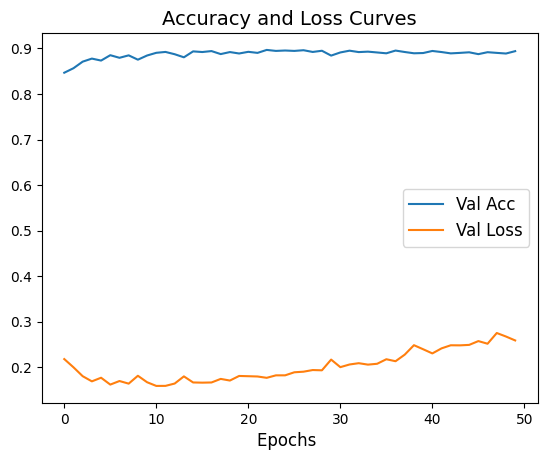

In [ ]:
from matplotlib import pyplot as plt

x_axis = [x for x in range(50)]
y_axis = history.history['val_accuracy']
y3 = history.history['val_loss']
plt.plot(x_axis, y_axis, x_axis,y3)
plt.xlabel('Epochs ',fontsize=12)
plt.legend(['Val Acc', 'Val Loss'],fontsize=12)
plt.title('Accuracy and Loss Curves',fontsize=14)

In [ ]:
eval_result = hypermodel.evaluate(img_test, label_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2839 - accuracy: 0.8851


In [ ]:
print("------------ SUMMARY ------------\n")
print(f"*Best Hyperparameters found:")
for key, value in best_hps.values.items():
 print(key,":",value)
print(f'\n*Hypermodel Evaluation:\nTest loss: {100*eval_result[0]:.2f} %\nTest accuracy: {100*eval_result[1]:.2f} %')
print(f"\n*Execution times:\nHyperparameter searching time: {search_duration:.2f} minutes \nHypermodel training time: {fit_duration:.2f} minutes")

------------ SUMMARY ------------

*Best Hyperparameters found:
units : 384
learning_rate : 0.001
loss_wgt1 : 0.5
loss_wgt2 : 0.0

*Hypermodel Evaluation:
Test loss: 28.39 %
Test accuracy: 88.51 %

*Execution times:
Hyperparameter searching time: 64.17 minutes 
Hypermodel training time: 7.95 minutes
